In [1]:
!pip install /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl

Processing /kaggle/input/segmentation-models-wheels/timm-0.6.12-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 KB 14.3 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/efficientnet_pytorch-0.7.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Processing /kaggle/input/segmentation-models-wheels/segmentation_models_pytorch-0.3.2-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 KB 18.4 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# basic modules
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm
from datetime import datetime
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython import display

# pytorch modules
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchvision.transforms import Normalize
from torch.multiprocessing import Pool

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.optim import lr_scheduler
import torchvision.transforms as T

from timm.scheduler import CosineLRScheduler

from skimage.transform import resize

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import segmentation_models_pytorch as smp

In [5]:
import torch_xla
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

In [6]:
base_dir = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/"
train_path = os.path.join(base_dir,"train")
test_path = os.path.join(base_dir,"test")
val_path = os.path.join(base_dir,"validation")

train_ids = os.listdir(train_path)
#train_ids = np.loadtxt("/kaggle/input/train-ids-existcontrail/train_ids_ExistContrail.csv", delimiter=",", dtype = "unicode")
#train_ids = train_ids.tolist()

test_ids = os.listdir(test_path)
val_ids = os.listdir(val_path)

In [7]:
def ash_transform(x, time_frame:int=4):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)
    if time_frame is not None:
        x = x[:,time_frame,:,:]
    def normalize_range(data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    r = normalize_range(x[2] - x[1], _TDIFF_BOUNDS)
    g = normalize_range(x[1] - x[0], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(x[1], _T11_BOUNDS)
    
    return np.clip(np.stack([r, g, b], axis=-3), 0, 1) # (T,3,H,W) or (3,H,W)

In [8]:
def random_horizontal_flip(video):
    horizontal = random.random()
    if horizontal < 0.5:
        return video[..., ::-1], horizontal
    return video, horizontal

def random_vertical_flip(video):
    vertical = random.random()
    if vertical < 0.5:
        return video[..., ::-1, :], vertical
    return video, vertical


def random_color(img, c=3): #(c, H, W)
    for i in range(c):
        bright_ratio = 0.01 * np.random.randint(75, 100)
        img[i] = bright_ratio * img[i]
    return img

def random_crop(img, output_size=(3, 256, 256)):
    c, h, w = img.shape #(c, H, W)

    # 元画像のアスペクト比を保持するために、クロップする正方形のサイズをランダムに選ぶ
    # ここでサイズを元の画像の50%から75%の範囲で選ぶ
    min_crop_size = int(min(h, w) * 0.70)
    max_crop_size = int(min(h, w) * 1.00)
    crop_size = np.random.randint(min_crop_size, max_crop_size)

    # 画像からクロップする部分の開始点（左上の座標）をランダムに選ぶ
    top = np.random.randint(0, h - crop_size)
    left = np.random.randint(0, w - crop_size)

    # その開始点から所定のサイズの部分をクロップ
    cropped_img = img[:, top: top + crop_size, left: left + crop_size]

    # scikit-imageのresize関数を使用して、クロップした画像を元のサイズにリサイズ
    # resize関数は (Height, Width, Channel) の順序を想定しているため、次元を並び替える
    resized_img = resize(np.transpose(cropped_img, (1, 2, 0)), output_size[1:], mode='reflect')

    # 最後に、元の次元の並び (Channel, Height, Width) に戻す
    resized_img = np.transpose(resized_img, (2, 0, 1))

    return resized_img, top, left, crop_size


def random_mask(img, mask_size=10, musk_num=20):
    i = 0
    for i in range(musk_num):
        if random.random() < 0.5:
            h, w = img.shape[-2:]
            top = random.randint(0, h - mask_size)
            left = random.randint(0, w - mask_size)
            img[..., top:top+mask_size, left:left+mask_size] = 0
            i += 1
    return img

def augment_video(video):
    #video = random_vertical_flip(video)  #正解データも反転させないとダメでは？
    #print(video.shape)
    video = np.stack([random_mask(frame) for frame in video.transpose(1, 0, 2, 3)])

    return video.transpose(1, 0, 2, 3)


# Test with dummy data
#video = np.random.rand(3, 10, 224, 224)
#augmented_video = augment_video(video)

In [9]:
class ContrailDataset(Dataset):
    def __init__(self, ids, base_dir, bands=None, transforms:list=[], test_mode:bool=False, aug=False):
        self.ids = ids
        self.base_dir = base_dir
        self.transforms = transforms
        self.bands = bands
        self.permute = (2,0,1)
        self.test_mode = test_mode
        self.aug = aug
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
    def __getitem__(self, index):
        record_id = self.ids[index]
        
        if self.bands is None:
            band_list = [f'band_{band:02d}.npy' for band in range(8,17)]
        else :
            band_list = [f'band_{int(band):02d}.npy' for band in self.bands]
        
        x = list()
        for band in band_list:
            x_path = os.path.join(self.base_dir, record_id, band)
            x.append(np.load(x_path).transpose(self.permute))

        x = np.stack(x,axis=1) ## X.shape = (Time_frame,channel,H,W)
        
        x = x.transpose((1,0,2,3)) ## PLUS ## X.shape = (channel, Time_frame ,H,W)
        
        #print(x.shape)
        
        for transformation in self.transforms:
            x = transformation(x)   # X.shape = (channel ,H,W)
             
        if self.aug: #aug would be applied only train-data which must be have target-data(y)
            #print(x.shape)
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = np.load(y_path).transpose(self.permute).astype(np.float32) #Y.shape = (channel ,H,W)
            
            x = np.concatenate((x, y), axis=0)
            x = random_mask(x) 
            y = x[3]
            y = np.expand_dims(y, axis=0)
            x = x[0:3]

            #x = random_mask(x)

            x = torch.from_numpy(x.astype(np.float32)).to(torch.float32)
            x = self.normalize_image(x)
            y = torch.from_numpy(y.astype(np.float32))
        
        if self.test_mode:
            x = torch.from_numpy(x.astype(np.float32)).to(torch.float32)
            x = self.normalize_image(x)
            return x
        
        elif self.aug:
            return x, y
        
        else:
            x = torch.from_numpy(x.astype(np.float32)).to(torch.float32)
            x = self.normalize_image(x)
            y_path = os.path.join(self.base_dir, record_id,'human_pixel_masks.npy')
            y = torch.from_numpy(np.load(y_path).transpose(self.permute).astype(np.float32))

            return x, y

    def __len__(self):
        return len(self.ids)
        

In [10]:
os.cpu_count()

96

In [11]:
# Datasets 
dataset_params = {
    "bands" : [11,14,15], 
    "transforms" : [ash_transform]
}
train_dataset = ContrailDataset(train_ids, train_path, **dataset_params, aug=True)
test_dataset = ContrailDataset(test_ids, test_path, test_mode=True, **dataset_params)
val_dataset = ContrailDataset(val_ids, val_path, **dataset_params)

# DalaLoaders
dataloader_params = {
    "batch_size" : 16,
    "shuffle" : True,
    "num_workers": 20,
    "drop_last": True
#     "pin_memory": True

}
train_loader = DataLoader(train_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2)
val_loader = DataLoader(val_dataset, **dataloader_params)

In [12]:
def plot_contrail(x, y, time_frame = 4):
    '''
    x = false color img of shape (8, 3, H, W)
    y = contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(y.permute(1,2,0), interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

    plt.show()

def plot_contrail_comparision(x, y_true, y_pred, time_frame = 4):
    '''
    x = false color img of shape (3, H, W) or (8, 3, H, W)
    y_true = target contrail mask of shape (1, H, W)
    y_pred = predicted contrail mask of shape (1, H, W)
    time_frame = int, default = 4
    '''
    if x.ndim == 4:
        x = x[time_frame]
    
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 5, 1)
    ax.imshow(x.permute(1,2,0))
    ax.set_title('False color image(x)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 2)
    ax.imshow(y_true.permute(1,2,0), interpolation='none')
    ax.set_title('True contrail mask(y_true)')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 3)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_true.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_true mask on x')
    ax.axis('off')
    
    ax = plt.subplot(1, 5, 4)
    ax.imshow(y_pred.permute(1,2,0), interpolation='none')
    ax.set_title('Pred contrail mask(y_pred)')
    ax.axis('off')

    ax = plt.subplot(1, 5, 5)
    ax.imshow(x.permute(1,2,0))
    ax.imshow(y_pred.permute(1,2,0), cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('y_pred mask on x')
    ax.axis('off')
    
    plt.show()

def animate_contrail(x):
    '''
    x = false color img of shape (8, 3, H, W)
    '''
    if x.ndim !=4:
        print(f"Incorrect input dimensions, Expected 4 recievied {x.ndim}.")
        return
    # Animation
    fig = plt.figure(figsize=(4, 4))
    im = plt.imshow(x[0].permute(1,2,0))
    def draw(i):
        im.set_array(x[i].permute(1,2,0))
        return [im]
    anim = animation.FuncAnimation(
        fig, draw, frames=x.shape[0], interval=100, blit=True
    )
    plt.close()
    return display.HTML(anim.to_jshtml())

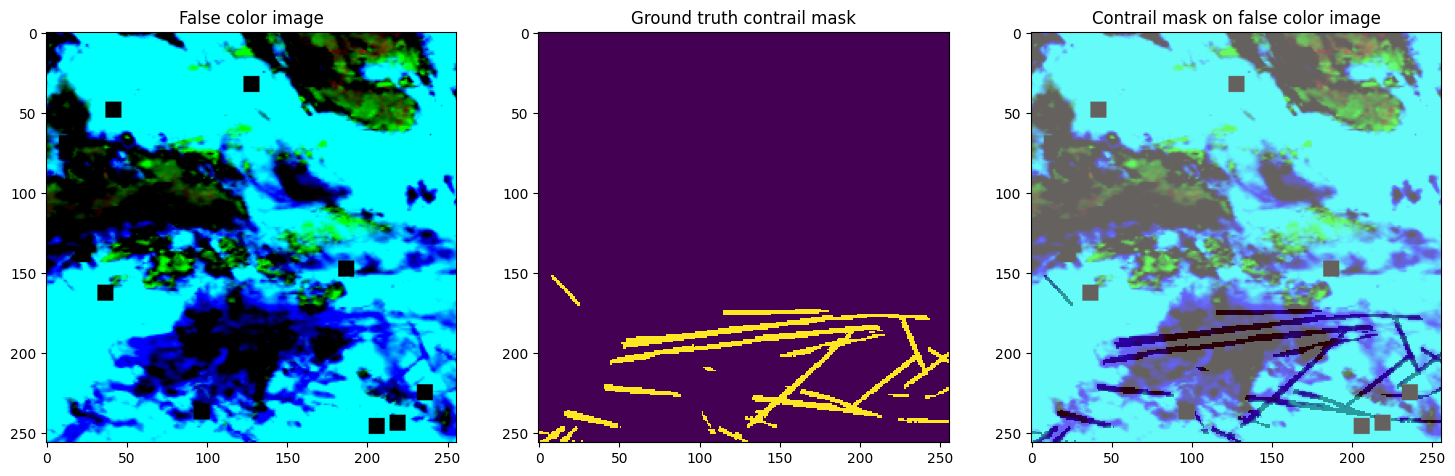

In [13]:
 x, y = train_dataset[train_ids.index('1704010292581573769')]
 plot_contrail(x, y)

In [14]:
# old type
'''# Dice Coefficient
def dice_coeff(mask1, mask2):
    intersect = torch.sum(mask1 * mask2)
    m1sum = torch.sum(mask1)
    m2sum = torch.sum(mask2)
    dice = (2 * intersect ) / (m1sum + m2sum)
    return dice.item()
'''

'# Dice Coefficient\ndef dice_coeff(mask1, mask2):\n    intersect = torch.sum(mask1 * mask2)\n    m1sum = torch.sum(mask1)\n    m2sum = torch.sum(mask2)\n    dice = (2 * intersect ) / (m1sum + m2sum)\n    return dice.item()\n'

In [15]:
def dice_coeff(y_p, y_t, smooth=1e-6):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    dice = torch.mean(score)
    return dice.item()

In [16]:
def dice_global(y_p,y_t,smooth=1e-3):

    intersection = torch.sum(y_p * y_t)
    union = torch.sum(y_p) + torch.sum(y_t)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def dice_loss_global(y_p,y_t):
    return 1-dice_global(y_p,y_t)

In [17]:
# Callbacks
class History:
    def __init__(self, print_prefix, save_to_disk=True):
        self.train_batch_history = []
        self.val_batch_histroy = []
        self.train_epoch_history = []
        self.val_epoch_history = []
        self.running_train_batch_history = []
        self.running_val_batch_history = []
        self.print_prefix = print_prefix
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states",self.print_prefix)
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
    def on_train_batch_end(self, data):
        self.running_train_batch_history.append(data)
        
    def on_val_batch_end(self, data):
        self.running_val_batch_history.append(data)
        
    def on_epoch_end(self):
        self.train_epoch_history.append(np.mean(self.running_train_batch_history))
        self.train_batch_history.extend(self.running_train_batch_history)
        self.running_train_batch_history=[]
        self.val_epoch_history.append(np.mean(self.running_val_batch_history))
        self.val_batch_histroy.extend(self.running_val_batch_history)
        self.running_val_batch_history=[]
        print(f"{self.print_prefix}: Train = {self.train_epoch_history[-1]:.6f} \
        | Val = {self.val_epoch_history[-1]:.6f}")
    
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            np.save(os.path.join(self.save_path,"train_batch.npy"),self.train_batch_history)
            np.save(os.path.join(self.save_path,"val_batch.npy"),self.val_batch_histroy)
            np.save(os.path.join(self.save_path,"train_epoch.npy"),self.train_epoch_history)
            np.save(os.path.join(self.save_path,"val_epoch.npy"),self.val_epoch_history)

In [18]:
class BestStateTracker:
    def __init__(self, model, optim, trigger:History, save_to_disk:bool = False):
        self.trigger = trigger
        self.model = model
        self.optim = optim
        self.optim_state = None
        self.model_state = None
        self.best_loss = np.inf
        self.save_to_disk = save_to_disk
        if save_to_disk:
            self.save_path = os.path.join(os.getcwd(),"saved_states")
            if not os.path.exists(self.save_path):
                os.mkdir(self.save_path)
                
    def on_epoch_end(self):
        if self.trigger.val_epoch_history[-1] < self.best_loss:
            self.model_state = self.model.state_dict()
            self.optim_state = self.optim.state_dict()
            
    def on_end(self):
        if self.save_to_disk:
            #dt = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            xm.save(self.model_state,os.path.join(self.save_path,f"model_state_end.pt"))
            xm.save(self.optim_state,os.path.join(self.save_path,f"optim_state_end.pt"))

In [19]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList()
        for dilation in dilations:
            self.aspp_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
                )

    def forward(self, x):
        return sum(block(x) for block in self.aspp_blocks)


In [20]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = ASPP(features * 8, features * 16, dilations=[1, 6, 12, 18])

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
    

In [21]:
device = xm.xla_device()

E0618 06:00:01.190623166     383 oauth2_credentials.cc:236]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {created_time:"2023-06-18T06:00:01.190604706+00:00", grpc_status:2}


In [22]:
model = UNet().to(device)

In [23]:
ENCODER = 'timm-efficientnet-b1' #'resnet101''timm-efficientnet-b4'
ENCODER_WEIGHTS = 'noisy-student' #'imagenet''noisy-student'

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

'''model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)'''

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_ns-99dd0c41.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_ns-99dd0c41.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 167MB/s] 


'model = smp.DeepLabV3Plus(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=1, \n    activation=ACTIVATION,\n).to(device)'

In [24]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      bce = self.bceloss(outputs, targets)
      bce_exp = torch.exp(-bce)
      focal_loss = 1 * (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [26]:
class LogCoshDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LogCoshDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        x = 1 - dice #diceloss
        
        return torch.log((torch.exp(x) + torch.exp(-x)) / 2.0)

In [27]:
!mkdir /kaggle/working/model

In [28]:
LR = 2e-3 #2e-3
EPOCHS = 10

FLAGS={}
FLAGS['num_cores'] = 8
FLAGS['start_epoch'] = 0
FLAGS['num_epochs'] = EPOCHS
FLAGS['num_workers'] = 12
FLAGS['log_steps'] = 100
FLAGS['seed'] = 123
FLAGS['max_lr'] = LR
FLAGS['min_lr'] = 0.00004
FLAGS['warmup_steps'] = 0

In [29]:
optimizer = Adam(params=model.parameters(), lr=LR)
#loss_fn = BCELoss()
loss_fn_1 = BCELoss()
loss_fn_2 = Focal_MultiLabel_Loss(gamma=2) 
loss_fn_3 = DiceLoss()
loss_fn_4 = LogCoshDiceLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=2)
'''scheduler = CosineLRScheduler(optimizer, 
                              t_initial=EPOCHS, 
                              lr_min=FLAGS['min_lr'], 
                              warmup_t=FLAGS['warmup_steps'],
                              warmup_lr_init=5e-6,
                              warmup_prefix=True)'''

loss_tracker = History(print_prefix="Loss")
dice_tracker = History(print_prefix="Dice")
save_state = BestStateTracker(model,optimizer,loss_tracker,save_to_disk=True)

In [30]:
WRAPPED_MODEL = xmp.MpModelWrapper(model)


def _map_fn(index, flags):
  pbar = tqdm(range(flags['start_epoch'], flags['num_epochs']))
  loss_best = 1.0
  torch.manual_seed(flags['seed'])

  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler=train_sampler,
    num_workers=flags['num_workers'],
    drop_last=True)
  
  val_sampler = torch.utils.data.distributed.DistributedSampler(
    val_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=False)

  val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 16,
    sampler=val_sampler,
    num_workers=flags['num_workers'],
    drop_last=False)

  for epoch in range(flags['start_epoch'], flags['num_epochs']):
    current_lr = optimizer.param_groups[0]['lr']
    xm.master_print(f"EPOCH: {epoch+1}/{flags['num_epochs']}, Learning rate: {current_lr}")
    para_train_loader = pl.ParallelLoader(train_loader, [device])
    model.train()
    
    for idx, (data, target) in enumerate(para_train_loader.per_device_loader(device)):
      y_pred = model(data)
      loss2 = loss_fn_2(y_pred, target) #Focal
      loss4 = loss_fn_4(y_pred, target) #DICE
      #loss4 = dice_loss_global(y_pred, target) #GlobalDICELoss
      loss  = 0.2 * loss2 + 0.8 * loss4
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      
      if idx % flags['log_steps'] == 0:
        xm.master_print(f'Train Batch: {idx+1}/{len(train_loader)} | Loss: {loss.item():.6f}')
        xm.master_print(f'FOCAL_Loss: {loss2.item():.6f}')
        xm.master_print(f'LogCoshDICE_Loss: {loss4.item():.6f}')
        
      loss_tracker.on_train_batch_end(loss.item())
      dice_tracker.on_train_batch_end(dice_coeff(y_pred>0.5, target))
      #pbar.set_description(f"Train Batch: {idx+1}/{len(train_loader)}\
      #| Loss: {loss.item():.6f}")

    plot_contrail_comparision(data[0].cpu().detach(),
                           target[0].cpu().detach(),
                           y_pred[0].cpu().detach()>0.5)
      
    model.eval()
    para_val_loader = pl.ParallelLoader(val_loader, [device])
    
    with torch.no_grad():
        for idx, (data, target) in enumerate(para_val_loader.per_device_loader(device)):
            y_pred = model(data)
            #loss =  loss_fn_3(y_pred, target) # Only DiceLoss for Validation
            loss = dice_loss_global(y_pred, target)
            loss_tracker.on_val_batch_end(loss.item())
            dice_tracker.on_val_batch_end(dice_coeff(y_pred>0.5, target))
            #pbar.set_description(f"Val Batch:   {idx+1}/{len(val_loader)}\
            #| Loss: {loss.item():.6f}")
            if idx % flags['log_steps'] == 0:
                xm.master_print(f'Val Batch: {idx+1}/{len(val_loader)} | GlobalDICELoss: {loss.item():.6f}')
                
        plot_contrail_comparision(data[0].cpu().detach(),
                        target[0].cpu().detach(),
                        y_pred[0].cpu().detach()>0.5)
    
                
    #xm.save(model.state_dict(), flags['save_path'])    
    scheduler.step(epoch)
    loss_tracker.on_epoch_end()
    dice_tracker.on_epoch_end()
    save_state.on_epoch_end()

  save_state.on_end()
  loss_tracker.on_end()
  dice_tracker.on_end()

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10, Learning rate: 0.002
Train Batch: 1/1283 | Loss: 0.370280
FOCAL_Loss: 0.151199
LogCoshDICE_Loss: 0.425051
Train Batch: 101/1283 | Loss: 0.110297
FOCAL_Loss: 0.032493
LogCoshDICE_Loss: 0.129749
Train Batch: 201/1283 | Loss: 0.117009
FOCAL_Loss: 0.031395
LogCoshDICE_Loss: 0.138413
Train Batch: 301/1283 | Loss: 0.085489
FOCAL_Loss: 0.031121
LogCoshDICE_Loss: 0.099081
Train Batch: 401/1283 | Loss: 0.072435
FOCAL_Loss: 0.031160
LogCoshDICE_Loss: 0.082753
Train Batch: 501/1283 | Loss: 0.100759
FOCAL_Loss: 0.024466
LogCoshDICE_Loss: 0.119832
Train Batch: 601/1283 | Loss: 0.093682
FOCAL_Loss: 0.034276
LogCoshDICE_Loss: 0.108534
Train Batch: 701/1283 | Loss: 0.093042
FOCAL_Loss: 0.022557
LogCoshDICE_Loss: 0.110663
Train Batch: 801/1283 | Loss: 0.104639
FOCAL_Loss: 0.078117
LogCoshDICE_Loss: 0.111269
Train Batch: 901/1283 | Loss: 0.109565
FOCAL_Loss: 0.034533
LogCoshDICE_Loss: 0.128323
Train Batch: 1001/1283 | Loss: 0.084307
FOCAL_Loss: 0.024114
LogCoshDICE_Loss: 0.099355
Train Batc

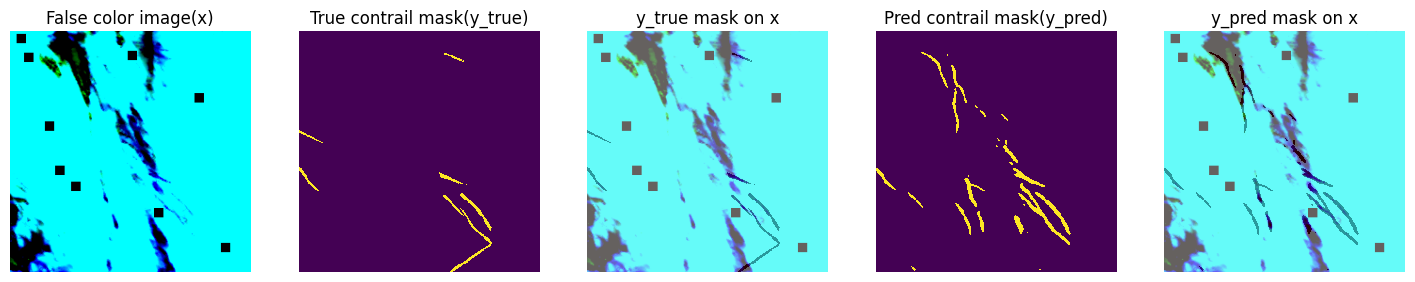

Val Batch: 1/116 | GlobalDICELoss: 0.440982
Val Batch: 101/116 | GlobalDICELoss: 0.483572


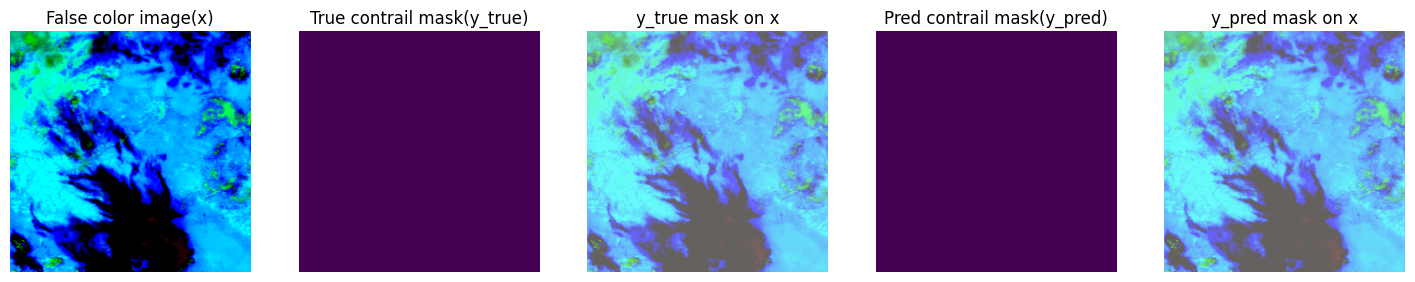

Loss: Train = 0.118049         | Val = 0.585984
Dice: Train = 0.558759         | Val = 0.622061
EPOCH: 2/10, Learning rate: 0.002
Train Batch: 1/1283 | Loss: 0.102149
FOCAL_Loss: 0.040756
LogCoshDICE_Loss: 0.117498
Train Batch: 101/1283 | Loss: 0.114107
FOCAL_Loss: 0.043172
LogCoshDICE_Loss: 0.131841
Train Batch: 201/1283 | Loss: 0.086199
FOCAL_Loss: 0.027497
LogCoshDICE_Loss: 0.100874
Train Batch: 301/1283 | Loss: 0.068781
FOCAL_Loss: 0.036281
LogCoshDICE_Loss: 0.076906
Train Batch: 401/1283 | Loss: 0.064128
FOCAL_Loss: 0.034574
LogCoshDICE_Loss: 0.071517
Train Batch: 501/1283 | Loss: 0.088968
FOCAL_Loss: 0.017449
LogCoshDICE_Loss: 0.106848
Train Batch: 601/1283 | Loss: 0.074624
FOCAL_Loss: 0.025067
LogCoshDICE_Loss: 0.087014
Train Batch: 701/1283 | Loss: 0.062044
FOCAL_Loss: 0.015252
LogCoshDICE_Loss: 0.073742
Train Batch: 801/1283 | Loss: 0.083060
FOCAL_Loss: 0.064206
LogCoshDICE_Loss: 0.087773
Train Batch: 901/1283 | Loss: 0.083962
FOCAL_Loss: 0.031138
LogCoshDICE_Loss: 0.097167
Tr

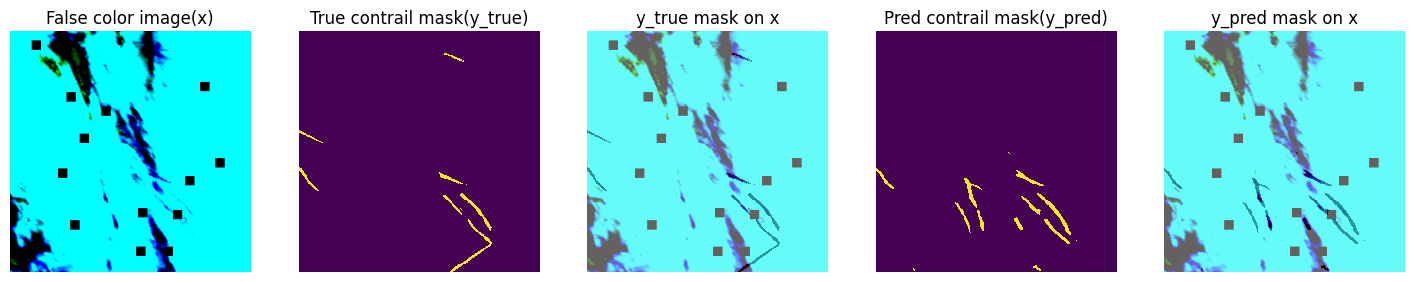

Val Batch: 1/116 | GlobalDICELoss: 0.444794
Val Batch: 101/116 | GlobalDICELoss: 0.432617


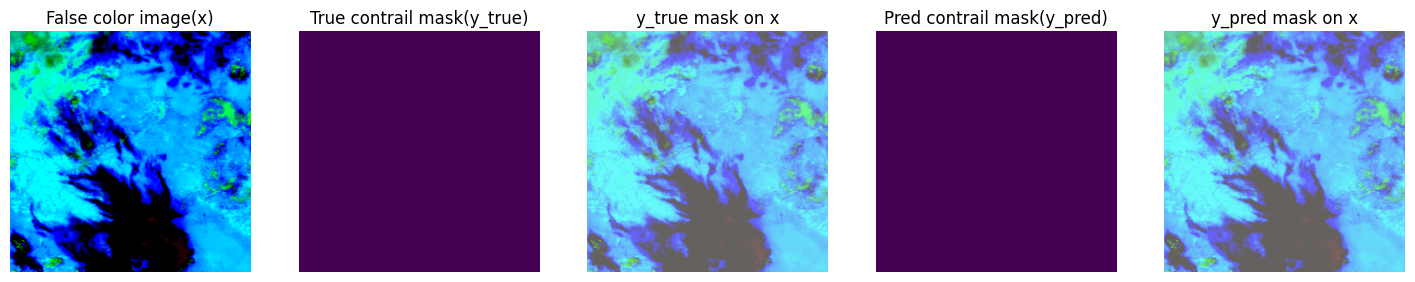

Loss: Train = 0.089828         | Val = 0.532606
Dice: Train = 0.627863         | Val = 0.732435
EPOCH: 3/10, Learning rate: 0.002
Train Batch: 1/1283 | Loss: 0.083212
FOCAL_Loss: 0.035451
LogCoshDICE_Loss: 0.095152
Train Batch: 101/1283 | Loss: 0.111589
FOCAL_Loss: 0.041444
LogCoshDICE_Loss: 0.129125
Train Batch: 201/1283 | Loss: 0.077456
FOCAL_Loss: 0.024464
LogCoshDICE_Loss: 0.090703
Train Batch: 301/1283 | Loss: 0.061600
FOCAL_Loss: 0.024828
LogCoshDICE_Loss: 0.070793
Train Batch: 401/1283 | Loss: 0.066924
FOCAL_Loss: 0.029798
LogCoshDICE_Loss: 0.076206
Train Batch: 501/1283 | Loss: 0.083085
FOCAL_Loss: 0.015507
LogCoshDICE_Loss: 0.099979
Train Batch: 601/1283 | Loss: 0.067721
FOCAL_Loss: 0.024747
LogCoshDICE_Loss: 0.078464
Train Batch: 701/1283 | Loss: 0.055592
FOCAL_Loss: 0.013492
LogCoshDICE_Loss: 0.066116
Train Batch: 801/1283 | Loss: 0.079675
FOCAL_Loss: 0.057409
LogCoshDICE_Loss: 0.085241
Train Batch: 901/1283 | Loss: 0.084362
FOCAL_Loss: 0.037126
LogCoshDICE_Loss: 0.096170
Tr

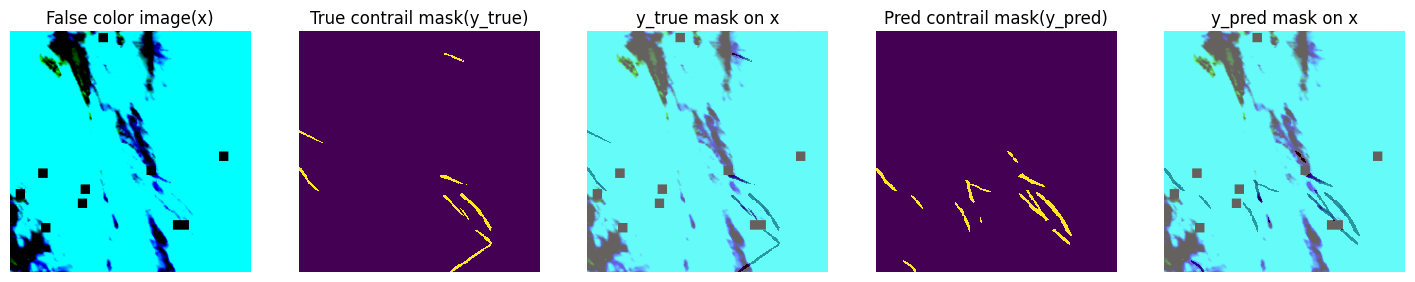

Val Batch: 1/116 | GlobalDICELoss: 0.413771
Val Batch: 101/116 | GlobalDICELoss: 0.423792


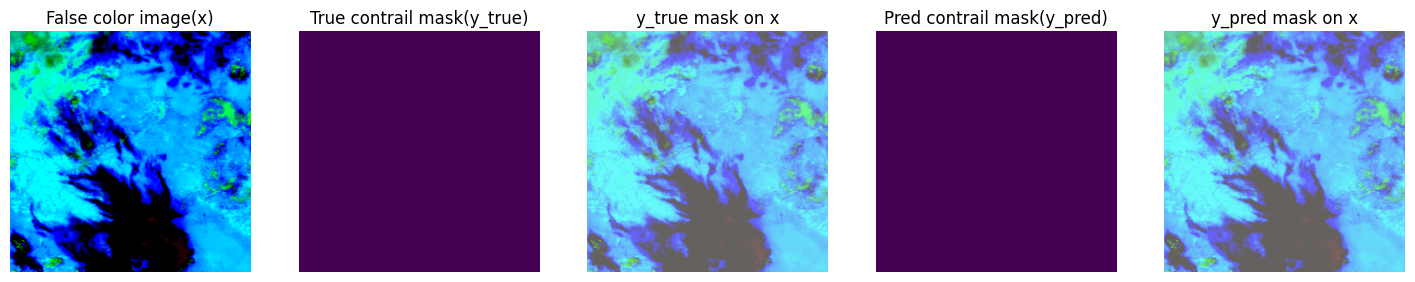

Loss: Train = 0.080672         | Val = 0.512639
Dice: Train = 0.658022         | Val = 0.734952
EPOCH: 4/10, Learning rate: 0.002
Train Batch: 1/1283 | Loss: 0.070252
FOCAL_Loss: 0.031271
LogCoshDICE_Loss: 0.079997
Train Batch: 101/1283 | Loss: 0.092914
FOCAL_Loss: 0.031467
LogCoshDICE_Loss: 0.108275
Train Batch: 201/1283 | Loss: 0.081540
FOCAL_Loss: 0.024510
LogCoshDICE_Loss: 0.095798
Train Batch: 301/1283 | Loss: 0.063090
FOCAL_Loss: 0.028793
LogCoshDICE_Loss: 0.071664
Train Batch: 401/1283 | Loss: 0.056884
FOCAL_Loss: 0.027625
LogCoshDICE_Loss: 0.064199
Train Batch: 501/1283 | Loss: 0.075981
FOCAL_Loss: 0.015259
LogCoshDICE_Loss: 0.091162
Train Batch: 601/1283 | Loss: 0.066127
FOCAL_Loss: 0.022154
LogCoshDICE_Loss: 0.077121
Train Batch: 701/1283 | Loss: 0.055190
FOCAL_Loss: 0.012660
LogCoshDICE_Loss: 0.065823
Train Batch: 801/1283 | Loss: 0.077508
FOCAL_Loss: 0.055180
LogCoshDICE_Loss: 0.083090
Train Batch: 901/1283 | Loss: 0.089971
FOCAL_Loss: 0.040895
LogCoshDICE_Loss: 0.102240
Tr

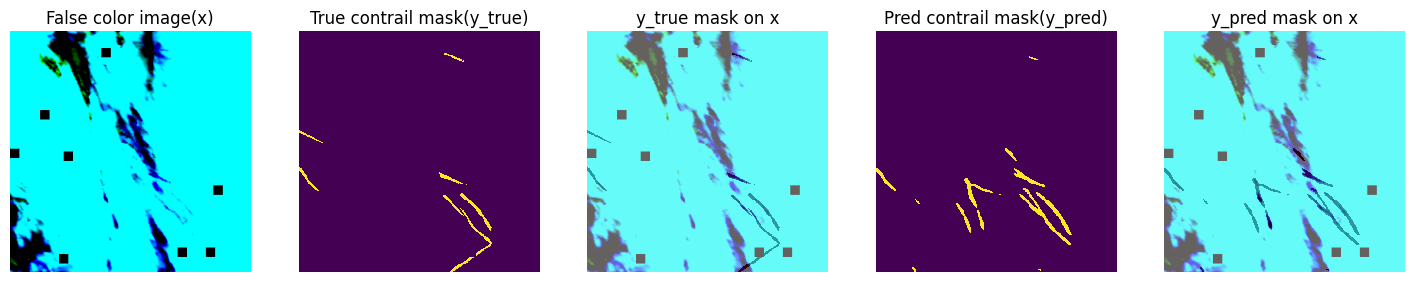

Val Batch: 1/116 | GlobalDICELoss: 0.383966
Val Batch: 101/116 | GlobalDICELoss: 0.407494


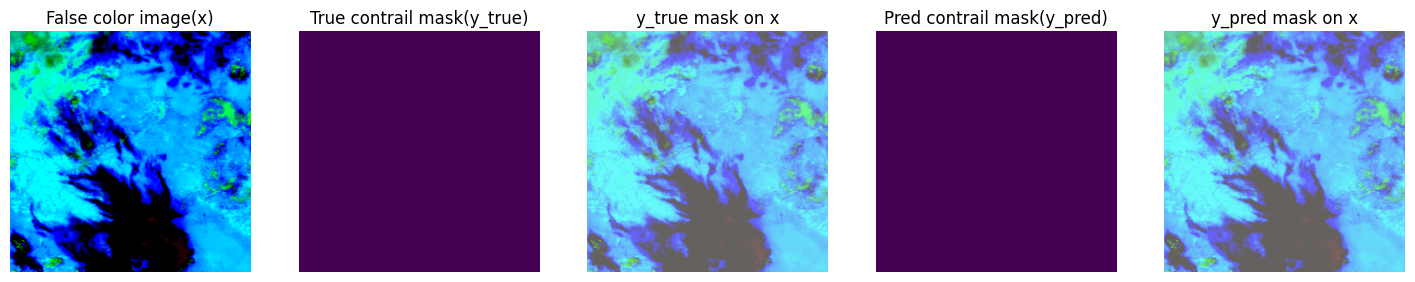

Loss: Train = 0.075541         | Val = 0.493813
Dice: Train = 0.678115         | Val = 0.722730
EPOCH: 5/10, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 0.064459
FOCAL_Loss: 0.027766
LogCoshDICE_Loss: 0.073633
Train Batch: 101/1283 | Loss: 0.087947
FOCAL_Loss: 0.028071
LogCoshDICE_Loss: 0.102916
Train Batch: 201/1283 | Loss: 0.070067
FOCAL_Loss: 0.021852
LogCoshDICE_Loss: 0.082121
Train Batch: 301/1283 | Loss: 0.058599
FOCAL_Loss: 0.023099
LogCoshDICE_Loss: 0.067474
Train Batch: 401/1283 | Loss: 0.053122
FOCAL_Loss: 0.025942
LogCoshDICE_Loss: 0.059916
Train Batch: 501/1283 | Loss: 0.064261
FOCAL_Loss: 0.012298
LogCoshDICE_Loss: 0.077252
Train Batch: 601/1283 | Loss: 0.051861
FOCAL_Loss: 0.017414
LogCoshDICE_Loss: 0.060473
Train Batch: 701/1283 | Loss: 0.041468
FOCAL_Loss: 0.011386
LogCoshDICE_Loss: 0.048989
Train Batch: 801/1283 | Loss: 0.074066
FOCAL_Loss: 0.050912
LogCoshDICE_Loss: 0.079855
Train Batch: 901/1283 | Loss: 0.088955
FOCAL_Loss: 0.030195
LogCoshDICE_Loss: 0.103645
T

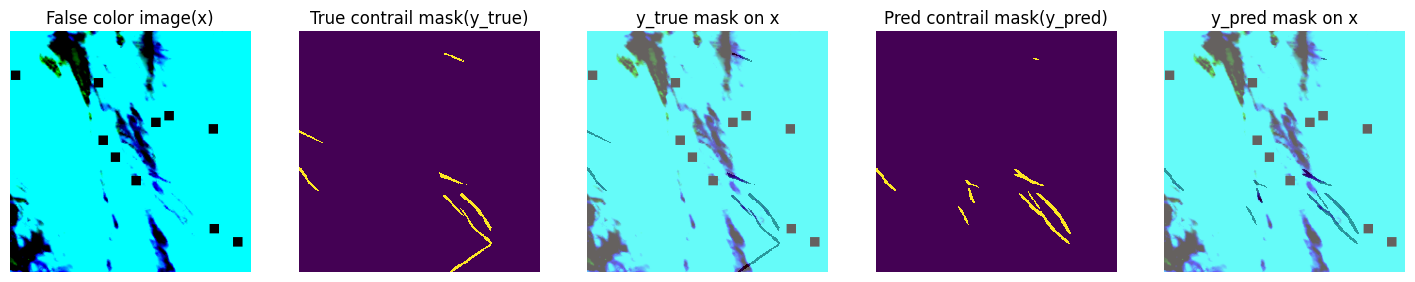

Val Batch: 1/116 | GlobalDICELoss: 0.391875
Val Batch: 101/116 | GlobalDICELoss: 0.375045


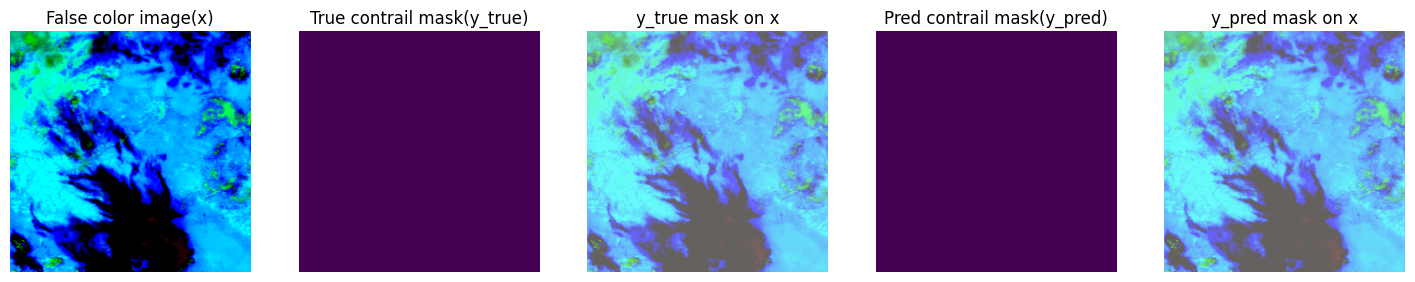

Loss: Train = 0.064172         | Val = 0.462346
Dice: Train = 0.716876         | Val = 0.779977
EPOCH: 6/10, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 0.062621
FOCAL_Loss: 0.026692
LogCoshDICE_Loss: 0.071603
Train Batch: 101/1283 | Loss: 0.085735
FOCAL_Loss: 0.028715
LogCoshDICE_Loss: 0.099990
Train Batch: 201/1283 | Loss: 0.066113
FOCAL_Loss: 0.020259
LogCoshDICE_Loss: 0.077576
Train Batch: 301/1283 | Loss: 0.056572
FOCAL_Loss: 0.022799
LogCoshDICE_Loss: 0.065015
Train Batch: 401/1283 | Loss: 0.048676
FOCAL_Loss: 0.024301
LogCoshDICE_Loss: 0.054770
Train Batch: 501/1283 | Loss: 0.068119
FOCAL_Loss: 0.013421
LogCoshDICE_Loss: 0.081794
Train Batch: 601/1283 | Loss: 0.049859
FOCAL_Loss: 0.017353
LogCoshDICE_Loss: 0.057986
Train Batch: 701/1283 | Loss: 0.030868
FOCAL_Loss: 0.008568
LogCoshDICE_Loss: 0.036443
Train Batch: 801/1283 | Loss: 0.071995
FOCAL_Loss: 0.049381
LogCoshDICE_Loss: 0.077648
Train Batch: 901/1283 | Loss: 0.118577
FOCAL_Loss: 0.042065
LogCoshDICE_Loss: 0.137705
T

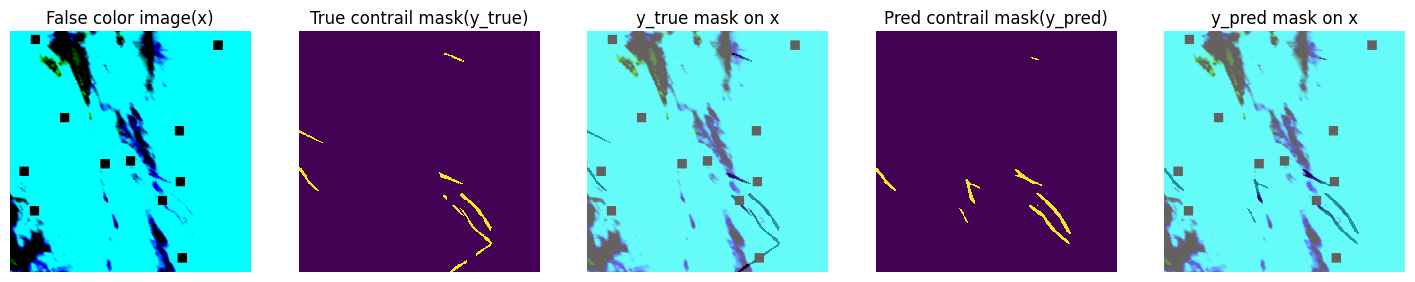

Val Batch: 1/116 | GlobalDICELoss: 0.384403
Val Batch: 101/116 | GlobalDICELoss: 0.370009


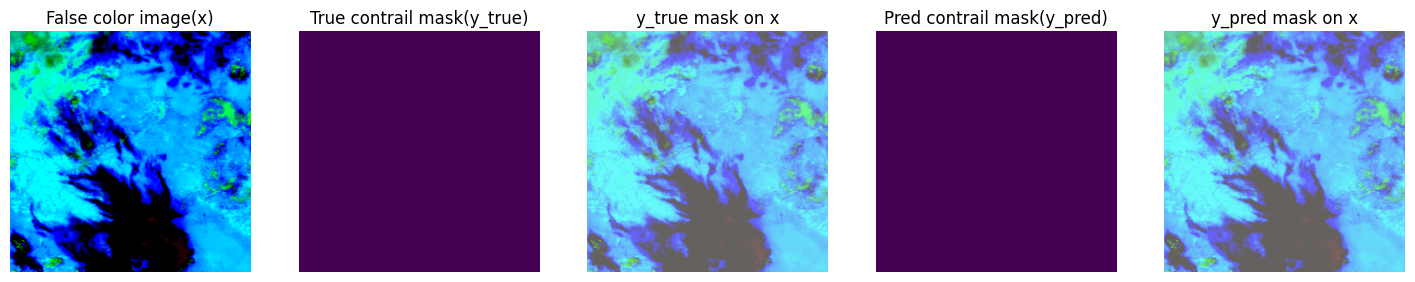

Loss: Train = 0.061082         | Val = 0.458039
Dice: Train = 0.725975         | Val = 0.774006
EPOCH: 7/10, Learning rate: 0.0005
Train Batch: 1/1283 | Loss: 0.058421
FOCAL_Loss: 0.025041
LogCoshDICE_Loss: 0.066766
Train Batch: 101/1283 | Loss: 0.083340
FOCAL_Loss: 0.029137
LogCoshDICE_Loss: 0.096891
Train Batch: 201/1283 | Loss: 0.061983
FOCAL_Loss: 0.020445
LogCoshDICE_Loss: 0.072367
Train Batch: 301/1283 | Loss: 0.055606
FOCAL_Loss: 0.022424
LogCoshDICE_Loss: 0.063901
Train Batch: 401/1283 | Loss: 0.052824
FOCAL_Loss: 0.026069
LogCoshDICE_Loss: 0.059513
Train Batch: 501/1283 | Loss: 0.062529
FOCAL_Loss: 0.012660
LogCoshDICE_Loss: 0.074996
Train Batch: 601/1283 | Loss: 0.046823
FOCAL_Loss: 0.016759
LogCoshDICE_Loss: 0.054339
Train Batch: 701/1283 | Loss: 0.040230
FOCAL_Loss: 0.009798
LogCoshDICE_Loss: 0.047838
Train Batch: 801/1283 | Loss: 0.072954
FOCAL_Loss: 0.050168
LogCoshDICE_Loss: 0.078651
Train Batch: 901/1283 | Loss: 0.075479
FOCAL_Loss: 0.027690
LogCoshDICE_Loss: 0.087426
T

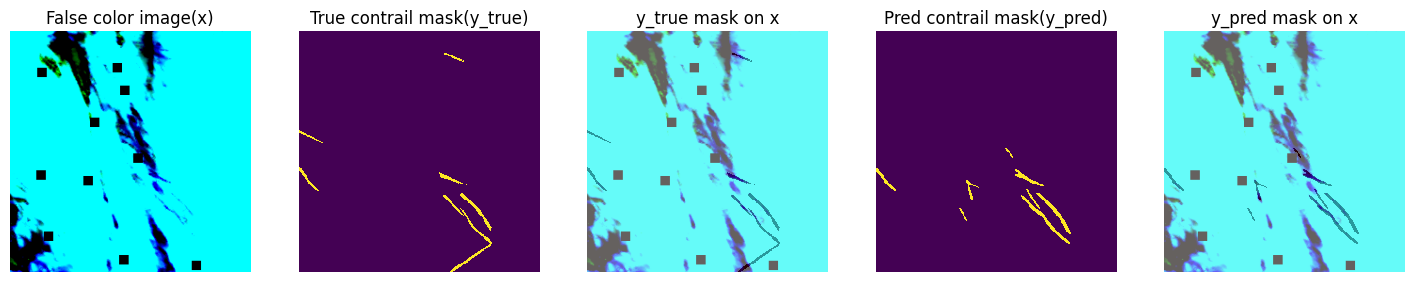

Val Batch: 1/116 | GlobalDICELoss: 0.369928
Val Batch: 101/116 | GlobalDICELoss: 0.374741


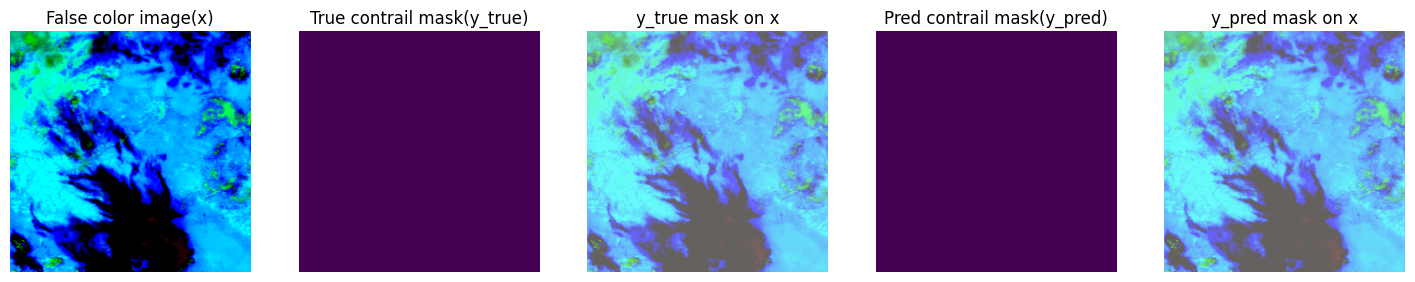

Loss: Train = 0.058876         | Val = 0.451001
Dice: Train = 0.734048         | Val = 0.766640
EPOCH: 8/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.051236
FOCAL_Loss: 0.024817
LogCoshDICE_Loss: 0.057841
Train Batch: 101/1283 | Loss: 0.073863
FOCAL_Loss: 0.029136
LogCoshDICE_Loss: 0.085045
Train Batch: 201/1283 | Loss: 0.060187
FOCAL_Loss: 0.019524
LogCoshDICE_Loss: 0.070353
Train Batch: 301/1283 | Loss: 0.051538
FOCAL_Loss: 0.020682
LogCoshDICE_Loss: 0.059251
Train Batch: 401/1283 | Loss: 0.047226
FOCAL_Loss: 0.023139
LogCoshDICE_Loss: 0.053248
Train Batch: 501/1283 | Loss: 0.057250
FOCAL_Loss: 0.012197
LogCoshDICE_Loss: 0.068513
Train Batch: 601/1283 | Loss: 0.041207
FOCAL_Loss: 0.015608
LogCoshDICE_Loss: 0.047607
Train Batch: 701/1283 | Loss: 0.032046
FOCAL_Loss: 0.008631
LogCoshDICE_Loss: 0.037899
Train Batch: 801/1283 | Loss: 0.066849
FOCAL_Loss: 0.046686
LogCoshDICE_Loss: 0.071889
Train Batch: 901/1283 | Loss: 0.052941
FOCAL_Loss: 0.021410
LogCoshDICE_Loss: 0.060824

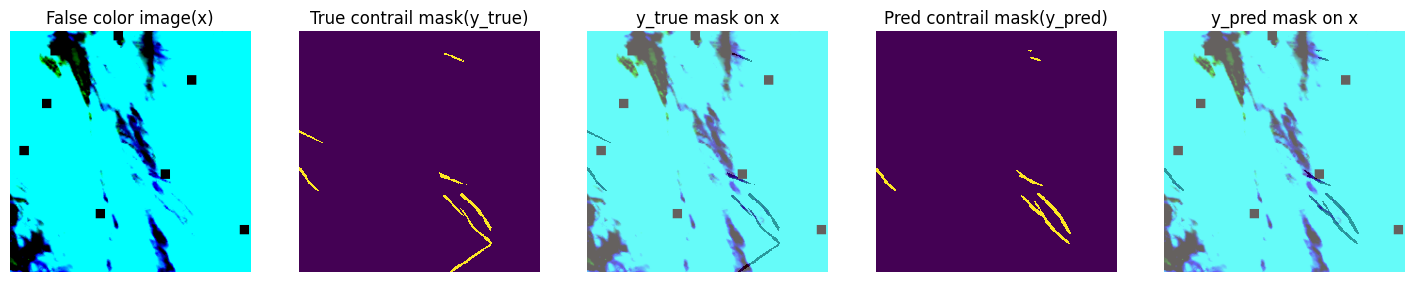

Val Batch: 1/116 | GlobalDICELoss: 0.401342
Val Batch: 101/116 | GlobalDICELoss: 0.367824


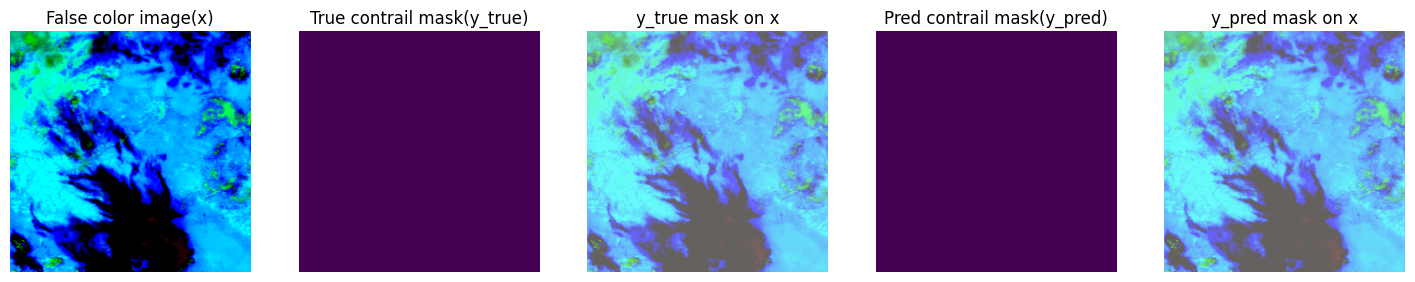

Loss: Train = 0.055771         | Val = 0.453742
Dice: Train = 0.742957         | Val = 0.789100
EPOCH: 9/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.060185
FOCAL_Loss: 0.026351
LogCoshDICE_Loss: 0.068643
Train Batch: 101/1283 | Loss: 0.089981
FOCAL_Loss: 0.030282
LogCoshDICE_Loss: 0.104906
Train Batch: 201/1283 | Loss: 0.054384
FOCAL_Loss: 0.017342
LogCoshDICE_Loss: 0.063645
Train Batch: 301/1283 | Loss: 0.050637
FOCAL_Loss: 0.020663
LogCoshDICE_Loss: 0.058130
Train Batch: 401/1283 | Loss: 0.043055
FOCAL_Loss: 0.021535
LogCoshDICE_Loss: 0.048435
Train Batch: 501/1283 | Loss: 0.057601
FOCAL_Loss: 0.011969
LogCoshDICE_Loss: 0.069009
Train Batch: 601/1283 | Loss: 0.043176
FOCAL_Loss: 0.016030
LogCoshDICE_Loss: 0.049962
Train Batch: 701/1283 | Loss: 0.030348
FOCAL_Loss: 0.008750
LogCoshDICE_Loss: 0.035748
Train Batch: 801/1283 | Loss: 0.067556
FOCAL_Loss: 0.045844
LogCoshDICE_Loss: 0.072984
Train Batch: 901/1283 | Loss: 0.056727
FOCAL_Loss: 0.021723
LogCoshDICE_Loss: 0.065478

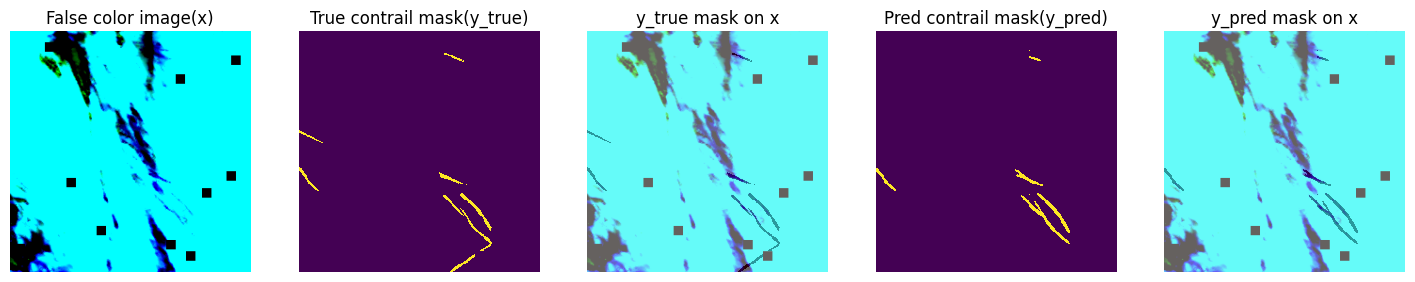

Val Batch: 1/116 | GlobalDICELoss: 0.407131
Val Batch: 101/116 | GlobalDICELoss: 0.363523


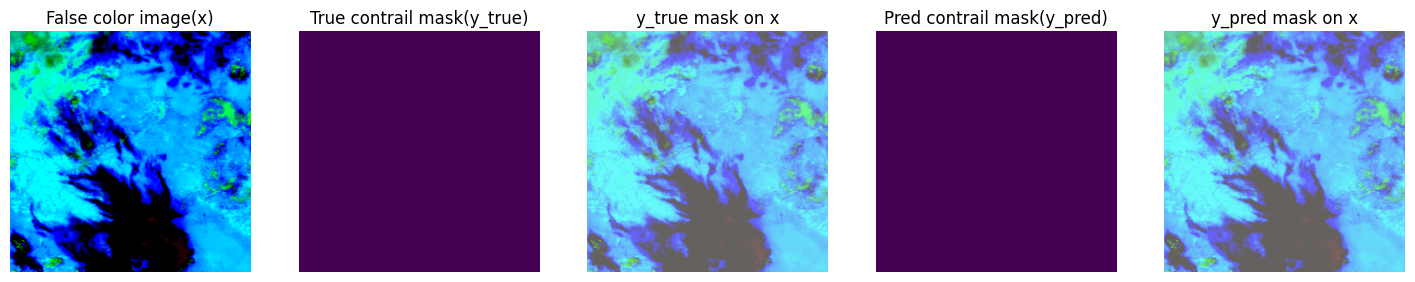

Loss: Train = 0.054688         | Val = 0.452458
Dice: Train = 0.746147         | Val = 0.792684
EPOCH: 10/10, Learning rate: 0.000125
Train Batch: 1/1283 | Loss: 0.052366
FOCAL_Loss: 0.025126
LogCoshDICE_Loss: 0.059176
Train Batch: 101/1283 | Loss: 0.076632
FOCAL_Loss: 0.027208
LogCoshDICE_Loss: 0.088988
Train Batch: 201/1283 | Loss: 0.058717
FOCAL_Loss: 0.019003
LogCoshDICE_Loss: 0.068646
Train Batch: 301/1283 | Loss: 0.050124
FOCAL_Loss: 0.020015
LogCoshDICE_Loss: 0.057651
Train Batch: 401/1283 | Loss: 0.045029
FOCAL_Loss: 0.022288
LogCoshDICE_Loss: 0.050714
Train Batch: 501/1283 | Loss: 0.053985
FOCAL_Loss: 0.011775
LogCoshDICE_Loss: 0.064537
Train Batch: 601/1283 | Loss: 0.040398
FOCAL_Loss: 0.015012
LogCoshDICE_Loss: 0.046745
Train Batch: 701/1283 | Loss: 0.031257
FOCAL_Loss: 0.008875
LogCoshDICE_Loss: 0.036852
Train Batch: 801/1283 | Loss: 0.065242
FOCAL_Loss: 0.044904
LogCoshDICE_Loss: 0.070327
Train Batch: 901/1283 | Loss: 0.058869
FOCAL_Loss: 0.023666
LogCoshDICE_Loss: 0.06766

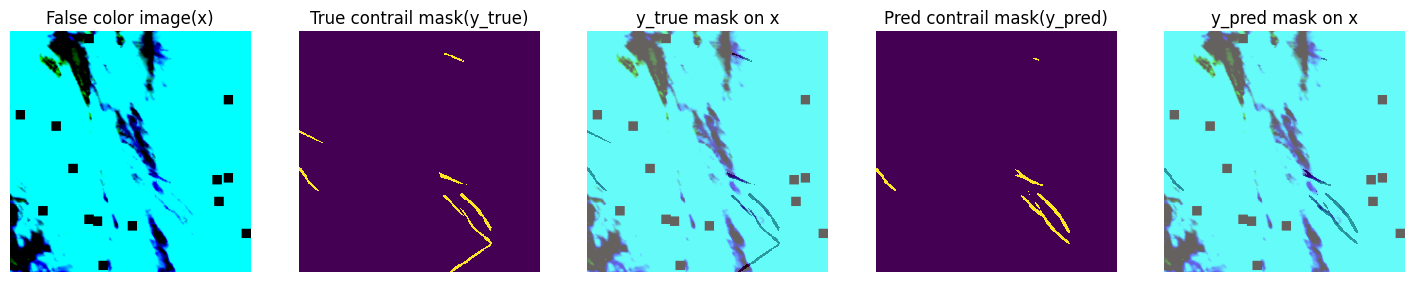

Val Batch: 1/116 | GlobalDICELoss: 0.393932
Val Batch: 101/116 | GlobalDICELoss: 0.369150


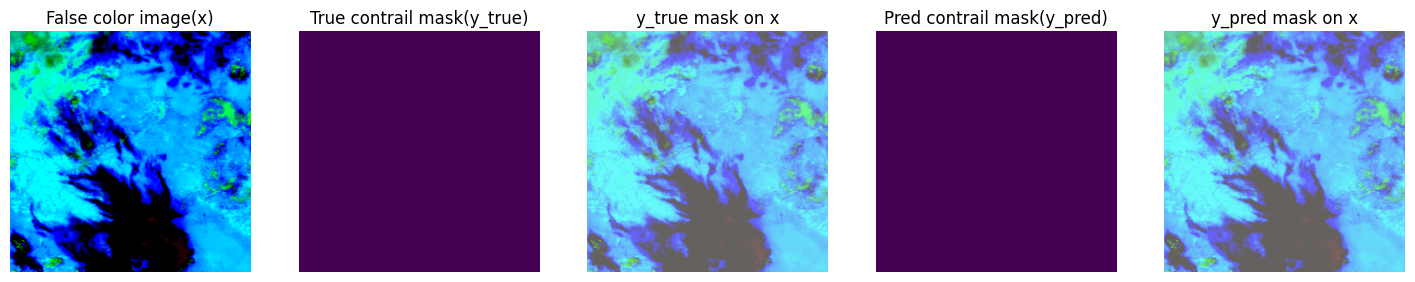

Loss: Train = 0.054239         | Val = 0.453267
Dice: Train = 0.747189         | Val = 0.792002


  0%|          | 0/10 [3:21:53<?, ?it/s]


In [31]:
xmp.spawn(_map_fn, args=(FLAGS,), nprocs=1, start_method='fork')